# **Import Modules**

In [1]:
import sys

import os

import random as pyrand

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sys.path.insert(0, '../input/deeplearning-utils')

In [2]:
from utils.ops import plot

from utils.tf.ops import io, eval as tf_eval

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

from tqdm import tqdm

In [4]:
from kaggle_secrets import UserSecretsClient
from kaggle_datasets import KaggleDatasets

In [5]:
import tensorflow as tf

from tensorflow.keras import backend, optimizers, regularizers

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential, Model

# from tensorflow.keras.applications import *

from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_addons as tfa

# **Config**

In [6]:
def set_seed(tf_seed=0, np_seed=0, py_rand=0, py_hash=0):

    os.environ['PYTHONHASHSEED'] = str(py_hash)
    pyrand.seed(py_rand)

    tf.random.set_seed(tf_seed)
    np.random.seed(np_seed)

In [7]:
PATH = {'224': 'cisc22placesandscene224x224'}

In [8]:
class Config:
    
    SEED = 2053
    
    IMAGE_SIZE = (224, 224)

    TRAIN_BATCH_SIZE = 32
    VAL_BATCH_SIZE = 32
        
    SPLIT =10
    
    TRAIN_SIZE = None
    
    EPOCHS = 100
    
    TRAINING = True
    
    WINDOW_SIZE = 7
    
    CROP_SIZE = WINDOW_SIZE * WINDOW_SIZE

In [9]:
set_seed(Config.SEED)

In [10]:
try:
    
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
    
except ValueError:
  
    tpu = None

if tpu is not None:
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    
    strategy = tf.distribute.get_strategy()


print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [11]:
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()

user_secrets.set_tensorflow_credential(user_credential)

GCS_DS_PATH = KaggleDatasets().get_gcs_path(PATH['224'])

In [12]:
augmentations = []

augmentations.append(preprocessing.RandomFlip(mode='horizontal'))
augmentations.append(preprocessing.RandomContrast(factor=0.8))
augmentations.append(preprocessing.RandomRotation(factor=0.1, dtype=tf.float32))

augmentations = Sequential(augmentations)

# **Load Data**

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

In [14]:
train_rec = tf.io.gfile.glob(GCS_DS_PATH + '/train/train/*')

train_rec = np.array(train_rec)

print(len(train_rec))

50


In [15]:
def train_processing(x, y):
        
    x = tf.cast(x, dtype=tf.float32)
    x /= 255.0
    
    y = tf.one_hot(y, depth=6)
    
    return augmentations(x, training=Config.TRAINING), y

In [16]:
def split_generator(train_idx, val_idx):
    
    dtype = {'image': 'bytes', 'label': 'int64'}
    
    reader = io.TfRecordReader(features_dtype=dtype,  image_key='image', 
                               tfrecord_shape=[*Config.IMAGE_SIZE, 3],  
                               shape=None, channels=3,  func=None)
    
    train_data = tf.data.TFRecordDataset(train_rec[train_idx], num_parallel_reads=AUTOTUNE)
    train_data = train_data.with_options(ignore_order)

    train_data = train_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    train_data = train_data.shuffle(512, reshuffle_each_iteration=True)
    train_data = train_data.batch(Config.TRAIN_BATCH_SIZE)
    train_data = train_data.prefetch(AUTOTUNE)
    train_data = train_data.map(train_processing)
    
    val_data = tf.data.TFRecordDataset(train_rec[val_idx], num_parallel_reads=AUTOTUNE)
    val_data = val_data.with_options(ignore_order)

    val_data = val_data.map(reader.read_tfrecord, num_parallel_calls=AUTOTUNE)
    val_data = val_data.batch(Config.VAL_BATCH_SIZE)
    val_data = val_data.prefetch(AUTOTUNE)
    val_data = val_data.map(train_processing)
    
    return train_data, val_data

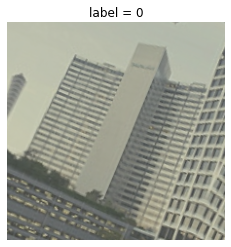

In [17]:
sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

plt.imshow(sample_x)
plt.title(f'label = {int(sample_y.argmax())}')
plt.axis('off')
plt.show()

# **Utils**

In [18]:
class ExtractPatches(Layer):

    def __init__(self, crop_size, *args, **kwargs):

        self.crop_size = crop_size

        super(ExtractPatches, self).__init__(*args, **kwargs)

    def extract_patches(self, image, padding='SAME'):

        channel_last = tf.transpose(image, perm=[2, 0, 1])
        channel_last = channel_last[..., None]

        patches = \
            tf.image.extract_patches(channel_last, sizes=[1, self.crop_size[0], self.crop_size[1], 1], padding=padding,
                                     strides=[1, self.crop_size[0], self.crop_size[1], 1], rates=[1, 1, 1, 1])

        patch_view = tf.transpose(patches, perm=[1, 2, 3, 0])

        shape = tf.shape(patch_view)

        num_patches = shape[0] * shape[1]
        size = self.crop_size[0] * self.crop_size[1] * shape[3]

        patch_view = \
            tf.reshape(patch_view, shape=(num_patches, size))

        return patch_view

    def get_outputs(self, patch_view, num_channels):
        
        patch_view = \
            tf.reshape(patch_view, shape=self.patch_view_shape(patch_view, num_channels))

        return patch_view

    def patch_view_shape(self, patch_view, num_channels):

        shape = patch_view.shape

        num_patches = shape[1]

        view_shape = (-1, num_patches, self.crop_size[0], self.crop_size[1], num_channels)

        return view_shape

    def map_extract_patches(self, inputs):

        outputs = tf.map_fn(self.extract_patches, inputs, fn_output_signature=inputs.dtype)

        return outputs

    def call(self, inputs, training=None):

        shape = inputs.shape

        num_channels = shape[-1]

        outputs = self.map_extract_patches(inputs)

        outputs = self.get_outputs(outputs, num_channels=num_channels)

        return outputs
    
    def get_config(self):
        
        cfg = super(ExtractPatches, self).get_config()
        
        cfg['crop_size'] = self.crop_size
        
        return cfg

(25, 49, 49, 3)


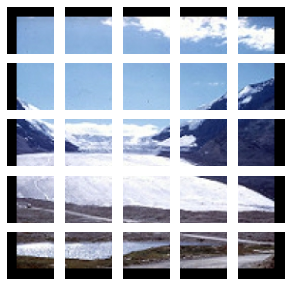

In [19]:
Config.TRAINING = False

sample_x, sample_y = split_generator(0, 1)[0].unbatch().as_numpy_iterator().next()

sample_x = tf.expand_dims(sample_x, axis=0)

sample_patches = ExtractPatches(crop_size=(Config.CROP_SIZE, Config.CROP_SIZE))(sample_x)
sample_patches = tf.squeeze(sample_patches, axis=0).numpy()

print(sample_patches.shape)

fig, axs = plot.plot(sample_patches, nrows=5, ncols=5, figsize=(5, 5))

Config.TRAINING = True

# **Build Model**

In [20]:
input_shape = (*Config.IMAGE_SIZE, 3)

In [21]:
@tf.function
def accuracy_score(y_true, y_pred):
    
    y_true = backend.argmax(y_true, axis=-1)
    y_pred = backend.argmax(y_pred, axis=-1)
    
    score = tf.equal(y_true, y_pred)
    score = tf.cast(score, dtype=tf.float32)
    
    return backend.mean(score)

In [22]:
def build_baseline_model():
    
    inputs = Input(shape=input_shape)
    
    # ===================================================================================

    patches = ExtractPatches(crop_size=(Config.CROP_SIZE, Config.CROP_SIZE))(inputs)
    
    # ===================================================================================

    proj = []
    
    for i in range(2):
        
        filters = 8
        window_size = 2 * i + 1
        
        z = TimeDistributed(Conv2D(filters=filters, kernel_size=(window_size, window_size), padding='same'))(patches)
        z = TimeDistributed(Activation('relu'))(z)
        
        proj.append(z)
        
    proj_skip = Add(name='proj_skip')(proj)
        
    # ===================================================================================

    value = ConvLSTM2D(filters=128, kernel_size=(Config.WINDOW_SIZE, Config.WINDOW_SIZE), padding='same', 
                       strides=Config.WINDOW_SIZE, go_backwards=True, return_sequences=True, name='value')(proj_skip)
        
    # ===================================================================================
    
    query = ConvLSTM2D(filters=6, kernel_size=(1, 1), name='query_logits', 
                       activation='tanh', go_backwards=True, return_sequences=True)(z)    
    
    # ===================================================================================
    
    attention = MultiHeadAttention(num_heads=6, key_dim=2, attention_axes=(2, 3), name='multi_head_attention')(query, value)
    
    # ===================================================================================

    attention_pool = TimeDistributed(GlobalAvgPool2D(), name='attention_pool')(attention)
        
    # ===================================================================================

    sequence_estimation = Bidirectional(LSTM(units=512), name='sequence_estimation')(attention_pool)
    
    # ===================================================================================
    
    y_logits = Dense(6, name='y_logits')(sequence_estimation)
    y_proba = Activation('softmax', name='y_proba')(y_logits)
    
    # ===================================================================================

    baseline_model = Model(inputs, y_proba)
    
    # ===================================================================================
    
    optimizer = optimizers.Adam(learning_rate=5e-05, beta_1=0.9, beta_2=0.999)
    
    loss = tf.losses.CategoricalCrossentropy(label_smoothing=0.1, name='categorical_crossentropy')
    metrics = tf.metrics.CategoricalAccuracy(name='accuracy_score')
    
    baseline_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # ===================================================================================

    return baseline_model

In [23]:
# build_baseline_model().summary()

# **Train Model**

In [24]:
weights_path = tf.io.gfile.glob('../input/cisc22placesandscenev0models/*.h5')

print(len(weights_path))

1


In [25]:
kfold = KFold(n_splits=Config.SPLIT, shuffle=False)

for i, (train_idx, val_idx) in enumerate(kfold.split(train_rec)):
    
    train_data, val_data = split_generator(train_idx, val_idx)
    
    print(f'fold {i} - {"=" * 100}')
    
    with strategy.scope():
        
        model = build_baseline_model()
    
    if i < len(weights_path):
        
        model.load_weights(weights_path[0])
        
    model.fit(train_data, epochs=Config.EPOCHS, validation_data=val_data, callbacks=None)
    
    model.save_weights(f'weights-{i}.h5')
    
    backend.clear_session()

    # stop cv
    if i == 0:
        
        break

fold 0 - ====================================================================================================
Epoch 1/100
384/384 [==============================] - 279s 652ms/step - loss: 0.8938 - accuracy_score: 0.8791 - val_loss: 0.9556 - val_accuracy_score: 0.8198
Epoch 2/100
384/384 [==============================] - 204s 528ms/step - loss: 0.7595 - accuracy_score: 0.8944 - val_loss: 0.8955 - val_accuracy_score: 0.8081
Epoch 3/100
384/384 [==============================] - 204s 527ms/step - loss: 0.7181 - accuracy_score: 0.8952 - val_loss: 0.8618 - val_accuracy_score: 0.8249
Epoch 4/100
384/384 [==============================] - 204s 527ms/step - loss: 0.6998 - accuracy_score: 0.8960 - val_loss: 0.8467 - val_accuracy_score: 0.8110
Epoch 5/100
384/384 [==============================] - 204s 527ms/step - loss: 0.6795 - accuracy_score: 0.9002 - val_loss: 0.8314 - val_accuracy_score: 0.8029
Epoch 6/100
384/384 [==============================] - 204s 527ms/step - loss: 0.6718 - accurac